<h1 style="font-size: 36px;">Constantin Gleyze</h1>

<p style="font-size: 30px;">
     Simulation of vanilla option prices (Call - Put) for different strikes using the following methods:
</<ul style="list-style-type: none;">
    <li style="font-size: 25px;">Calculation via option premium simulation</li>
    <li style="font-size: 25px;">Batch Method</li>
    <li style="font-size: 25px;">Practitioner's Method</li>
    <li style="font-size: 25px;">Adaptive Method</li>
<p></p>
</p>


The objective of this nano-project is to estimate the price of a vanilla option using several estimation methods within the framework of the Black-Scholes model. We denote the underlying price by $S_T^x$, whose dynamic under the risk-neutral probability $\mathbb{Q}$ is given by:
$$dS_t^x = S_t^x ( r dt + \sigma dW_t) ,$$
where $W_t$ is geometrib Brownian motion under $\mathbb{Q}$, $r \geq 0$ is the risk-free rate, $\sigma > 0$ is the volatility, and $S_0^x = x >  0$ is the initial value of the underlying asset.


In [38]:
#Importation of our main librairies we will use

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import time
import pandas as pd
from IPython.display import display, HTML

# <div style="font-size: 20px;">1. Creation of Our Base Functions and Methods</div>

 # <div style="font-size: 15px;">1.1. Base Functions </div>

We generate our space and initialization for the creation of our random processes.

In [39]:
from numpy.random import default_rng, SeedSequence
sq = SeedSequence() #Seed initialization
rng = default_rng(sq) #Random sequence generation algorithm implementation


We create a function that enables us to generate brownian paths.

In [40]:
def brownian_simulation(paths : int, times : np.ndarray, increments : bool=False, rng: np.random.Generator = None) -> np.ndarray : 
    if rng is None : 
        rng = np.random.default_rng() #Create a seed and an subsequent algorithm if not provided

    #We sort the discretisation of our time and compute the lenght each time to detemrine the variance of our gaussian processes
    np.sort(times)
    time_lenght = np.diff(times).astype(np.float32)

    #We compute our points
    brownian_paths = (np.sqrt(time_lenght)*rng.standard_normal((paths, len(time_lenght)))).astype(np.float32)
    
    #Only return the increments between each points
    if increments : 
        return brownian_paths.ravel()
        
    #Return otherwise the trajectories of our brownian motion, necessiting the sum the increments from 0
    paths = np.hstack([np.zeros((paths,1)).astype(np.float32), np.cumsum(brownian_paths, axis=1)])
    
    return paths              

The dynamic of our underlying asset under the risk-neutral probability $\mathbb Q$ is : 

$$S_t = S_0e^{(r - \frac{\sigma^2}{2})t + \sigma W_t}$$

where $W_t$ is a Brownian motion under $\mathbb{Q}$, $r \geq 0$ is the risk-free rate, $\sigma > 0$ is the volatility, and $S_0^x = x > 0$ is the initial value of the underlying asset.


We therefore define a function to generate our underlying price at the time $T$. 

In [1]:
#Some of our methods require to generate two series of price in order to get a variance reduction
#Because we will need to generate to serie of prices from the same probability space, we add an option to choose one or two series of prices and use the same seed that generated the brownian motion
def underlying_prices (S0, r, sigma, T,n, double_prices_series = False) : 
    brownian_paths = brownian_simulation(paths=n, times=np.array([0.0, T]), increments = True,rng=rng)

    #Because of the symmetry of the geometric brownian motion, we use the negative value of the generated brownian motion to generate our second prices' serie
    if double_prices_series : 
        S1 = S0*np.exp((r - 0.5*(sigma**2))*T + sigma*brownian_paths)
        brownian_paths = -brownian_paths
        S2 = S0*np.exp((r - 0.5*(sigma**2))*T + sigma*brownian_paths)
        return S1,S2
        
    else : 
        return  S0*np.exp((r - 0.5*(sigma**2))*T + sigma*brownian_paths)

The payoff of the call option at $T$ is given by:

$$
\Pi_T^{\text{Call(T,K)}}(S_T^x) = (S_T^x-K)_+
$$

and that of the put option at $T$ given by : 

$$
\Pi_T^{\text{Put(T,K)}}(S_T^x) = (K-S_T^x)_+
$$

We therefore define functions that reproduce these payoffs as well as a function to directly generate our actualized payoff (underlying then actualized payoff). 



In [42]:
def payoff_call (S, K) : 
    return np.maximum(S-K,0)

def payoff_put (S, K) : 
    return np.maximum(K-S,0)

#As the title says. We generate our prices and apply the payoff function we are interested within
def generate_actualized_simulations_payoff (S0, r, sigma,K, T,n, payoff_function, double_prices_series = False):
    if double_prices_series : 
        S1,S2 = underlying_prices (S0, r, sigma, T,n,double_prices_series=True)
        S1 = S1.astype(np.float32)
        S2 = S2.astype(np.float32)
        S1 = np.exp(-r*T)*payoff_function(S1,K)
        S2 = np.exp(-r*T)*payoff_function(S2,K)
        return S1,S2
        
    else :                          
        S = underlying_prices (S0, r, sigma, T,n,double_prices_series = False).astype(np.float32)
        return np.exp(-r*T)*payoff_function(S,K)

The price of a call at the time t=0 is given by the formula from Black & Scholes : 

$$C_0(T,K) = S_0\mathcal{N}(d_+) - Ke^{-rT}\mathcal{N}(d_-)$$

The price of an equivalent put, using the call-put parity is : 

$$P_0(T,K) = C_0(T,K) - S_0+ Ke^{-rT}$$

with $\mathcal{N}$ the cumulative distribution function (CDF) of a standard normal random variable with:

$$d_+ = \frac{\log\left(\frac{x}{Ke^{-rT}}\right)+\frac{\sigma^2}{2}T}{\sigma\sqrt{T}}.$$

and

$$d_- = d_+ - {\sigma\sqrt{T}}$$

We define our functions to compute the exact theoric vanilla option's prices to better estimate the quality of our future estimators.

In [3]:
#Black Scholes closed formula
def call_price(S0, r, sigma, T, K,n=1) : 
    d1 = (np.log(S0/(K*np.exp(-r*T))) + (sigma**2)*(T/2))/(sigma*np.sqrt(T)).astype(np.float32)
    d2 = d1 - sigma*np.sqrt(T).astype(np.float32)
    call_price= S0*norm.cdf(d1) - K*(np.exp(-r*T))*norm.cdf(d2)
    return np.full(n, call_price).astype(np.float32)


#Using Call-Put parity
def put_price (S0, r, sigma, T, K,n=1) : 
    return call_price (S0, r, sigma, T, K,n)  - S0 + K*np.exp(-r*T).astype(np.float32)

During the description and implementation of each method, we will use the notation $X_k$ referring to the $k^{th}$ simulation of our option's payoff. 

We assume the sequence $ (X_k)_{k=1}^n $ is i.i.d. for all  $n \geq 0$

# <div style="font-size: 20px;">The methods we will use </div>

 # <div style="font-size: 15px;">1.2. Classic Monte Carlo </div>

We first perform a "classic" Monte Carlo simulation to simulate our premium. This method has a high variance, which we will seek to reduce subsequently during this nano-project.

$$
\sqrt{n} \left( \overline{X}_n - m_X \right) \xrightarrow{\mathcal{L}} \mathcal{N}(0, \sigma_X^2) \quad \text{as } n \to +\infty,
$$

with 
$$
\overline{X_n} = \frac{1}{n}\sum_{k=1}^n{X_k} \quad \text{and} \quad m_X = \mathbb{E}[X_1] \quad \text{and} \quad \sigma_X^2 = \mathbb{V}[X_1],
$$

and therefore, if we define our error as:
$$
\epsilon_n = \overline{X}_n - m_X,
$$

we can derive that:
$$
\epsilon_n \xrightarrow{\mathcal{L}} \mathcal{N}\left(0, \frac{\sigma_X^2}{n}\right).
$$


In [44]:
def MC_option_simulation (S,serie=False,nb_simu=1000,var=False):

    #We can choose to return the cumulated MC to have a better idea of the convergence according to the number of simulations
    if serie : 

        #We extract a sub_set of several MC processes (number_simulations) to have an idea of the convergence of the serie
        #A first try, faster has been done with cumsum. However, the approximation done through the sum iterations resulted in false results with n > 1M
        #An approach using the single MC simulation price through a recursive approach, slower but more precise has therefore been chosen
        indices= np.linspace(0, len(S), nb_simu, dtype=int)
        serie = np.array([MC_option_simulation(S[:i],serie=False,nb_simu=nb_simu,var=var) for i in indices])   
        return serie 

    else: 

        #We can choose to return the variance of our error in addition to the MC price
        if var : 
            return np.mean(S),(len(S)/((len(S)-1))*((np.sum(S**2)/len(S)) - np.mean(S)**2))/len(S)
        else : 
            return np.mean(S)

 # <div style="font-size: 15px;">1.3. Batch approch  </div>

This approach uses the antithetic approach which aims to reduce the variance of our error and therefore improve the quality of the predictions.

We introduce a dynamic real control variable $\lambda$ such that:

$$
X^{\lambda} = X - \lambda \Xi
$$

where $X$ and $X'$ follow the same distribution, i.e.

$$
\mathbb{E}[X] = \mathbb{E}[X'] = m_X, \quad \mathbb{V}[X] = \mathbb{V}[X'] = \sigma_X^2
$$

but with $\mathbb{V}[X - X'] > 0$, and $\Xi$ is defined as:

$$
\Xi = X - X'
$$

The variance of $X^{\lambda}$ is minimized when:

$$
\lambda_{\min} = \frac{\text{cov}(X, \Xi)}{\text{Var}[\Xi]}
$$

### Simulation Setup

The simulation is performed using:

$$
\overline{X}_n^\lambda = \frac{1}{n} \sum_{k=1}^n X_k^\lambda
$$

or equivalently:

$$
\overline{X}_n^\lambda = \overline{X}_n + \overline{\lambda}_n \overline{\Xi}_n
$$

where:

$$
\overline{\lambda}_n = \frac{\frac{1}{n} \sum_{k=1}^n X_k (X_k - X_k')}{\frac{1}{n} \sum_{k=1}^n (X_k - X_k')^2}
$$

and:

$$
\overline{\Xi}_n = \frac{1}{n} \sum_{k=1}^n (X_k - X_k')
$$

### Asymptotic Behavior

We have the asymptotic convergence:

$$
\sqrt{n} \left( \overline{X}_n^\lambda - m_X \right) \xrightarrow{\mathcal{L}} \mathcal{N}(0, \sigma_{\min}^2) \quad \text{as } n \to +\infty
$$

or equivalently:

$$
\left( \overline{X}_n^\lambda - m_X \right) \xrightarrow{\mathcal{L}} \mathcal{N}\left(0, \frac{\sigma_{\min}^2}{n}\right) \quad \text{as } n \to +\infty
$$
with : 

$$\sigma_{\min}^2 \leq \sigma_X^2$$


In [45]:
def Batch_approach (S1,S2,serie=False,nb_simu = 1000,parameters=False, var=False): 

    #Implementation of theta
    theta = S1-S2    

    #We can choose to return the cumulated MC to have a better idea of the convergence according to the number of simulations
    if serie : 
        
        #We extract a sub_set of several MC processes (number_simulations) to have an idea of the convergence of the serie
        #A first try, faster has been done with cumsum. However, the approximation done through the sum iterations resulted in false results with n > 1M
        #An approach using the single MC simulation price through a recursive approach, slower but more precise has therefore been chosen
        indices= np.linspace(0, len(S1), nb_simu, dtype=int)
        serie = np.array([Batch_approach(S1[:i],S2[:i],serie=False,nb_simu = nb_simu,parameters=parameters, var=var) for i in indices])   
        return serie 

        if parameters: 
            return lambda1
        else : 
            return averaged_S1 - lambda1*averaged_theta
    else: 

        #Creation of our lambda Batch parameter we will use to compute the estimate price
        param_lambda = np.mean(S1*theta)/np.mean(theta**2)
        
        if parameters : 
            return param_lambda
        else : 

            #Computation of simulated payoff and theta mean for the Batch price, used whether the variance of the error is provided or not
            S1_mean = np.mean(S1)
            theta_mean = np.mean(S1-S2)
            
            #We can choose to return the variance of our error in addition to the MC price
            if var : 
                
                indices = np.arange(1, len(theta) + 1, dtype=np.float32)
                
                #Creation of our cumulated simulation theta square 2 average to compute our parameter lambda Batch 
                partial_theta_squared = theta**2
                cumulative_theta_squared = np.cumsum(partial_theta_squared)
                averaged_theta_squared = cumulative_theta_squared / indices

                #In order to avoid the division by 0, we create a security by remplacing 0 value by a very low value epsilon
                epsilon = 1e-10
                averaged_theta_squared = np.maximum(averaged_theta_squared, epsilon)

                #Creation of our parameter lambda Batch
                partial_lambda1 = S1 * theta
                cumulative_lambda1 = np.cumsum(partial_lambda1)
                averaged_lambda1 = cumulative_lambda1 / indices
                lambda1 = averaged_lambda1/averaged_theta_squared

                #Return of the Batch price and the variance of the error of the serie on which the average is computed
                return S1_mean - param_lambda*theta_mean, (len(S1)/(len(S1)-1))*((np.sum(((S1 - lambda1*theta)**2)/len(S1)) - np.mean(S1 - lambda1*theta)**2))/len(S1)
                
            else : 
                
                #Return solely of the Batch price
                return S1_mean - param_lambda*theta_mean

 # <div style="font-size: 15px;">1.4. Practitioner’s corner  </div>

However, in practice, we have the following relationship:

$$
\overline{X}_n^{\lambda_{\min}} = \overline{X}_n - \lambda_{\min} \overline{\Xi}_n
$$

Taking expectations on both sides, we get:

$$
\mathbb{E}[\overline{X}_n^{\lambda_{\min}}] = \mathbb{E}[\overline{X}_n] -  \mathbb{E}[\lambda_{\min} \overline{\Xi}_n]
$$

i.e,

$$
\mathbb{E}[\overline{X}_n^{\lambda_{\min}}] = m -  \mathbb{E}[\lambda_{\min} \overline{\Xi}_n]
$$

However, in practice, $\mathbb{E}[\lambda_{\min} \overline{\Xi}_n] \neq 0$.

To address this issue of biais, we also calculate using what is called the "Practitioner's Corner":

We set $n' < n$.

We simulate $(X_k, X_k')_{k=1}^{n'}$ and construct $\hat{\lambda}$ such that:

$$
\hat{\lambda}_{n'} = \frac{\frac{1}{n'} \sum_{k=1}^{n'} X_k (X_k - X_k')}{\frac{1}{n'} \sum_{k=1}^{n'} (X_k - X_k')^2}
$$

Then, we construct our estimator $\overline{X}_{n-n'+1}$:

$$
\overline{X}_{n-n'} = \frac{1}{n-n'} \sum_{k=n^{'}+1}^{n} X_k + \frac{\hat{\lambda}_{n'}}{n-n'} \sum_{k=n^{'}+1}^{n} \Xi_k
$$

We then have:

$$
\mathbb{E}[\overline{X}_{n-n'}^{\lambda_{\min}}] = m - \mathbb{E}[\hat{\lambda}_{n'} \overline{\Xi}_{n-n'}]
$$

or equivalently:

$$
\mathbb{E}[\overline{X}_{n-n'}^{\lambda_{\min}}] = m - \mathbb{E}[\hat{\lambda}_{n'}] \cdot \mathbb{E}[\overline{\Xi}_{n-n'}]
$$

With:

$$
\mathbb{E}[\overline{\Xi}_{n-n'}] = 0
$$

Thus, the estimator $\overline{X}_{n-n'}^{\lambda_{\min}}$ is unbiased. 


In [46]:
def Practitioner_corner (S1,S2,serie=False,nb_simu=1000, var = False): 
    
    #We can choose to return the cumulated MC to have a better idea of the convergence according to the number of simulations
    if serie :
        
        #We extract a sub_set of several MC processes (number_simulations) to have an idea of the convergence of the serie
        #A first try, faster has been done with cumsum. However, the approximation done through the sum iterations resulted in false results with n > 1M
        #An approach using the single MC simulation price through a recursive approach, slower but more precise has therefore been chosen
        indices= np.linspace(0, len(S1), nb_simu, dtype=int)
        serie = np.array([Practitioner_corner(S1[:i],S2[:i],serie=False,nb_simu=nb_simu, var = var) for i in indices])   
        return serie 
    
    else : 

        #We separate our total power of computation into a "training" set of lenght n_1 to approximation our lambda practitionner and on the "computation set" of lenght n_2 to compute our estimated price
        n_1 = int(np.floor(0.15*len(S1)))
        n_2 = len(S1) - n_1
    
        #Implementation of theta
        theta = S1-S2
        
        #Computation of our lambda practitionner on the "training set" of lenght n_1
        lambda_practionner = np.mean(S1[:n_1] * theta[:n_1]) / np.mean(theta[:n_1] ** 2)
    
        #Computation of simulated payoff and theta mean for the Batch price, used whether the variance of the error is provided or not
        S1_mean = np.mean(S1[n_1+1:])
        theta_mean = np.mean(theta[n_1+1:])

        #We can choose to return the variance of our error in addition to the MC price
        if var : 
            return S1_mean - lambda_practionner*theta_mean, (len(S1[n_1:])/(len(S1[n_1:])-1))*((np.sum(((S1[n_1:] - lambda_practionner*theta[n_1:])**2)/len(S1[n_1:])) - np.mean(S1[n_1:] - lambda_practionner*theta[n_1:])**2))/len(S1[n_1:])

        else : 

            #Return solely of the Practitioner price
            return S1_mean - lambda_practionner*theta_mean

# <div style="font-size: 15px;">1.5. Adaptative approach  </div>

Another approach exists, called the adaptive approach, to address this bias problem without splitting our effort -as done in the Practitioner's Corner-.

We define : 

$$
\tilde{X}_k = X_k - \tilde{\lambda}_{k-1} \Xi_k
$$

where:

$$
\tilde{\lambda}_{k} = \big((-k) \lor \lambda_k\big) \land k
$$

with $\lambda_k$ the parameter from our Batch approach. 

Our estimator is thereby computed as : 

$$
\overline{\tilde{X}}_n = \overline{X}_n - \frac{1}{n} \sum_{k=1}^{n} \tilde{\lambda}_{k-1} \Xi_k
$$

or : 

$$
\overline{\tilde{X}}_n = \overline{X}_n - \tilde{\lambda}_{k-1} \overline{\Xi}_k
$$


In [47]:
def Adaptative_approach (S1,S2,serie=False, nb_simu = 1000, var=False): 

    #Implementation of theta
    theta = S1-S2


    #We can choose to return the cumulated MC to have a better idea of the convergence according to the number of simulations
    if serie :
        
        #We extract a sub_set of several MC processes (number_simulations) to have an idea of the convergence of the serie
        #A first try, faster has been done with cumsum. However, the approximation done through the sum iterations resulted in false results with n > 1M
        #An approach using the single MC simulation price through a recursive approach, slower but more precise has therefore been chosen
        indices= np.linspace(0, len(S1), nb_simu, dtype=int)
        serie = np.array([Adaptative_approach(S1[:i],S2[:i],serie=False, nb_simu = nb_simu, var=var) for i in indices])   
        return serie 
     
    else : 

        #Computation of simulated payoff and theta mean for the Adapative price as well as our lambda parameter, used whether the variance of the error is provided or not
        S1_mean = np.mean(S1)
        theta_mean = np.mean(S1-S2)
        lambda_adaptative_one_price = min(max((np.mean((S1[:-1] * theta[:-1]))/np.mean((theta[:-1] ** 2))),-(len(S1)-1)),len(S1)-1)

        #We can choose to return the variance of our error in addition to the MC price
        if var : 
            
            indices = np.arange(1, len(theta) + 1, dtype=np.float32)
            #Creation of our cumulated simulation theta square 2 average to compute our parameter lambda Batch 
            partial_theta_squared = theta**2
            cumulative_theta_squared = np.cumsum(partial_theta_squared)
            averaged_theta_squared = cumulative_theta_squared / indices

            #In order to avoid the division by 0, we create a security by remplacing 0 value by a very low value epsilon
            epsilon = 1e-10
            averaged_theta_squared = np.maximum(averaged_theta_squared, epsilon)

            #Creation of our cumulated lambda Batch
            partial_lambda1 = S1 * theta
            cumulative_lambda1 = np.cumsum(partial_lambda1)
            averaged_lambda1 = cumulative_lambda1 /indices
            lambda1 = averaged_lambda1/averaged_theta_squared
            
            #From the Batch parameter, we apply the formula for the adaptative parameter 
            lambda_adaptative_no_shifted= np.maximum(-indices, np.minimum(lambda1,indices))
            
            #We shift our lambda from one to the left to well multiply by lambda_k_-1 to keep the shift recurrence relationship
            lambda_adaptative = np.concatenate(([0], lambda_adaptative_no_shifted[:-1]))
            
            #Return of the Adaptative price and the variance of the error of the serie on which the average is computed
            return S1_mean - lambda_adaptative_one_price*theta_mean, (len(S1)/(len(S1)-1))*((np.sum(((S1 - lambda1*theta)**2)/len(S1)) - np.mean(S1 - lambda1*theta)**2))/len(S1)
            
        else : 

            #Return solely of the Adaptative price
            return S1_mean - lambda_adaptative_one_price*theta_mean

# <div style="font-size: 20px;">2. Functions to display results</div>

# <div style="font-size: 15px;">2.1. Function to display a panda dataframe of our results</div>

In [48]:
#This function will show for there number of simulation our error as well as our variance

def print_results_panda (S0,r,sigma,T,K, prix_option, payoff_function, n_values, series = False,title="") : 

    #We want to know the time to compute the exact time to compute our prices and payoff 
    beginning1 = time.time() 

    #We generate our prices 
    S1, S2 = underlying_prices (S0, r, sigma, T,max(n_values), double_prices_series = True)
    S1 = S1.astype(np.float32)
    S2 = S2.astype(np.float32)
    
    #To construct our payoff structure,, it may seem counter-intuititve but it is faster with a loop rather than with zip (tested)
    S1_complete, S2_complete = [],[]
    for f in payoff_function : 
        S1_complete.append(np.exp(-r*T)*f(S1,K))
        S2_complete.append(np.exp(-r*T)*f(S2,K))
        
    end1 = time.time() 
    execution_time1 = end1 - beginning1

    #We print the execution time
    print(f"Time execution for the generation of {len(payoff_function)*max(n_values):,} prices and associated payoff : {execution_time1:.2f} seconds")

    #We loop for all the different type of option we want to display
    for i in range (len(prix_option)) : 

        #We compute our reference price i.e the BS one
        BS_price = prix_option[i] (S0, r, sigma, T, K,1)

        times = np.array([]) 
        
        #We prepare our numpy to stock our data
        errors_mc = np.array([])
        errors_batch = np.array([])
        errors_practitioner = np.array([])
        errors_adaptative = np.array([]) 
        
        vars_mc = np.array([])
        vars_batch = np.array([])
        vars_practitioner = np.array([])
        vars_adaptative = np.array([]) 

        #We loop on the different number of simulation we want to have a look at
        for n in n_values :
    
            #We simulate our actualized payoff according to the prices we simulate
            S1 = np.asarray(S1_complete[i][:n])
            S2 = np.asarray(S2_complete[i][:n])

            #We want to time our computations to verify if we have well a linear relationship between our number of simulations and the variance reduction method's execution time
            beginning = time.time()  
    
            #For each method, we compute the price, the variance and we store the error relative to the BS price and the var
    
            #Classic Monte Carlo method
            mc_price,var_mc = MC_option_simulation (S1,serie=series, var=True)
            errors_mc = np.append(errors_mc, mc_price - BS_price)
            vars_mc = np.append(vars_mc,var_mc)
    
            #Batch method
            batch_price,var_batch =  Batch_approach (S1,S2,serie=series, var=True)
            errors_batch =  np.append(errors_batch, batch_price - BS_price)
            vars_batch = np.append(vars_batch,var_batch)
    
            #Practitioner method
            practitioner_price,var_practitioner =  Practitioner_corner (S1,S2,serie=series, var=True)
            errors_practitioner =  np.append(errors_practitioner, practitioner_price - BS_price)
            vars_practitioner = np.append(vars_practitioner,var_practitioner)
    
            #Adaptative method
            adaptative_price,var_adaptative =  Adaptative_approach (S1,S2, serie=series,var=True)
            errors_adaptative =  np.append(errors_adaptative, adaptative_price - BS_price)
            vars_adaptative = np.append(vars_adaptative,var_adaptative)
    
            #We stock our execution time 
            end = time.time() 
            execution_time = end - beginning
            times = np.append(times,execution_time)
    
        #Creation of our DataFrame to display the results
        results = pd.DataFrame({
            'Nb simulation': [f"{x:,}" for x in n_values],
            'Time computation 4 estimators from payoff series':times,
            'Error Classic MC': errors_mc,
            'Error Batch approach' : errors_batch,
            'Error Practionner approach' : errors_practitioner,
            'Error Adaptative approach' : errors_adaptative,
            'Var error Classic MC ': vars_mc,
            'Var error Batch approach ': vars_batch,
            'Var error Practionner approach ': vars_practitioner,
            'Var error MC Adaptative approach': vars_adaptative,
        })
    
        #To add and align to the center a title to our dataframe, we use html
        html_template = f"""
        <div style="display: flex; flex-direction: column; align-items: center;">
            <div style="text-align: center; font-size: 20px; font-weight: bold; margin-bottom: 10px;">
                {title[i]}
            </div>
            {results.to_html(index=False)}
        </div>
        """
        
        display(HTML(html_template))


# <div style="font-size: 15px;">2.2. Function to display and analyse our error's convergence speed to 0 according to the number of simulation </div>

In [4]:
#This function has for goal to compute our errors to feed the plot function below
from matplotlib.collections import LineCollection

def generate_data_convergence_error_according_to_n (K,S1,S2,BS_price,option_type,nb_simu_wanted) : 

    #We compute our prices
    
    mc_price = MC_option_simulation (S1,serie=True, nb_simu = nb_simu_wanted)
    error_mc = np.abs(mc_price-BS_price)
    
    batch_price =  Batch_approach (S1,S2,serie=True,nb_simu = nb_simu_wanted)
    batch_errors = np.abs(batch_price-BS_price)

    practitioner_price =  Practitioner_corner (S1,S2,serie=True,nb_simu = nb_simu_wanted)
    practitioner_errors = np.abs(practitioner_price-BS_price)
   
    adaptative_price =  Adaptative_approach (S1,S2,serie=True,nb_simu = nb_simu_wanted)
    adaptative_errors = np.abs(adaptative_price-BS_price)

    #We convert our numpy into list, which would make it easier to plot through matplotlib
    data = [arr for arr in [error_mc, batch_errors, practitioner_errors, adaptative_errors]]
    data = [[f"{option_type}",K]]+data
    
    return data

#This function will plot a sample of MC methods between 0 and the number of simulation given to show the speed of convergence
#To have a referential, the CV rate of 1 / sqrt(nb simulations) is also plot
#We can decide the number of points we want to generate 
#Classic plot function that can dynamically adapt itself according to the number of "set of data" we give to it 
#It will do as many graphs as "set of data" are given, two maximum per rows
def print_data_convergence_error_according_to_n (S0,r,sigma,T,K,n, prix_option, payoff_function,option_type,nb_simu_wanted=1000,zoom =0) : 
    datas = []

    #We simulate our prices and check the time taken
    beginning1 = time.time() 
    S1, S2 = underlying_prices (S0, r, sigma, T,n, double_prices_series = True)
    end1 = time.time() 
    execution_time1 = end1 - beginning1
    
    # Computation of errors
    beginning2 = time.time()

    for K_i in K : 
        for i in range(len(option_type)) : 
            
            #We compute our actualized payoff simulations according to the payoff function asked 
            #We can not do it for all at the beginning because of the different strikes we are looking at
            S1_bis = np.exp(-r*T)*payoff_function[i](S1,K_i)
            S2_bis = np.exp(-r*T)*payoff_function[i](S2,K_i)
            
            #We compute our reference value through the closed formula of Black Sholes 
            BS_price = prix_option[i] (S0, r, sigma, T, K_i,1)

            #We generate our errors series to plot according to each type of option we want to display
            #To have a fast but less precise result, we can compute only few nb_simu_wanted or in the contrary increase it
            datas.append(generate_data_convergence_error_according_to_n (K_i,S1_bis,S2_bis,BS_price,option_type[i],nb_simu_wanted))

    end2 = time.time() 
    execution_time2 = end2 - beginning2


    #Adapt dynamically the number of plot to be done with 2 plots per row 
    num_graphs = len(datas)  
    num_cols = 2                 
    num_rows = (num_graphs + 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 5))
    axes = axes.ravel()

    #We plot our data and we time it also 
    beginning3 = time.time() 

    #We introduce a zoom option to have a closer look of the convergence. 
    #Indeed, the CV is very fast near to 0 and becomes slower after, making the graphics unadapted
    #If zoom is 15%, we exclude the 15% first values
    #If the user wants to zoom, this part adjusts consequently the absice axis
    zoom_index = int(zoom*nb_simu_wanted)
    n_values = np.linspace(0, len(S1), nb_simu_wanted, dtype=int)
    n_values_zoomed = n_values[zoom_index:]
    n_values_sqrt = n_values_zoomed
    if zoom ==0 : n_values_sqrt[0]=1
    inverse_sqrt_n_values = 1 / np.sqrt(n_values_sqrt)
    
    for idx, dataset in enumerate(datas):
        ax = axes[idx]

        # Stock our data and label to plot
        plot_data = [
            
            {"data": dataset[1][zoom_index:], "label": "Monte Carlo Simulation", "color": "blue"},
            {"data": dataset[2][zoom_index:], "label": "Batch Method", "color": "green"},
            {"data": dataset[3][zoom_index:], "label": "Practitioner Method", "color": "purple"},
            {"data": dataset[4][zoom_index:], "label": "Adaptive Method", "color": "orange"},
            
            # CV reference 1 / sqrt(n)
            {"data": inverse_sqrt_n_values, "label": r"$\frac{1}{\sqrt{n}}$", "color": "red", "linestyle": "--"} 
        ]
        
        # Plot
        for entry in plot_data:
            ax.plot(
                n_values_zoomed,
                entry["data"],  
                '-',
                label=entry["label"],
                color=entry["color"]
            )

        #Do the legend of our graphes
        ax.set_title(f"{dataset[0][0]} pricing error according to the numbers\nof simulations with K = {dataset[0][1]}", fontsize=10)
        ax.set_xlabel("Number of simulations (n)")
        ax.set_ylabel(f"{dataset[0][0]} pricing error")
        ax.legend()
        ax.grid(True)
    

    # Delete unused axis
    for idx in range(len(datas), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

    end3 = time.time() 
    execution_time3 = end3 - beginning3

    #Print results of time execution
    print(f"Time {n:,} prices generation: {execution_time1:.2f} seconds")
    print(f"Time computation estimators series for each K and each payoff function: {execution_time2:.2f} seconds")
    print(f"Time plot : {execution_time3:.2f} seconds")


# <div style="font-size: 15px;">2.3. Function to display our approximation error for several strikes and different number of simulations </div>

In [5]:
#To change a little, we do our plot function as a sub function
#Classic plot function

def graphe_result(strikes, prices, n,option_type): 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    #Figure to plot our approximation of the price (ax1) and the error with the BS price (ax2)

    ax1.plot(strikes, prices[0], '-', color ='red', label='Black-Scholes')
    ax1.plot(strikes, prices[1], '-', color ='blue', label='Monte Carlo Simulation')
    ax1.plot(strikes, prices[2], '-', color ='green', label='Batch Method')
    ax1.plot(strikes, prices[3], '-', color ='purple', label='Practitioner Method')
    ax1.plot(strikes, prices[4], '-', color ='orange', label='Adaptive Method')

    #We legend our graphs
    ax1.set_title(f"{option_type} price as a function of K ({n:,} simulations)",fontsize=10 )
    ax1.set_xlabel("Strike (K)")
    ax1.set_ylabel(f"{option_type} price")
    ax1.legend()
    
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[0], prices[1])], '-', color ='blue', label='Difference with Monte Carlo Simulation')
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[0], prices[2])], '-', color ='green', label='Difference with Batch Method')
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[0], prices[3])], '-', color ='purple', label='Difference with Practitioner Method')
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[0], prices[4])], '-', color ='orange', label='Difference with Adaptive Method')

    #We legend our graphs
    ax2.set_title(f"Difference between each method and the \nBlack-Scholes price ({n:,} simulations)", fontsize=10 )
    ax2.set_xlabel("Strike (K)")
    ax2.set_ylabel(f"Difference in {option_type} price")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

#This function generate the data of our prices and errors for several strikes for a given number of simulations and call the plot function
def plot_result (S0,r,sigma,T,strikes,number_simulations,prix_option,payoff_function,option_type): 

    #Creation of our data structure to receive our prices and errors for our five way to compute (BS closed formula and four MC methods)
    prices = [[[] for i in range(5)] for k in range(len(number_simulations))]

    beginning1 = time.time()  
    
    #  #We simulate our prices
    S1, S2 = underlying_prices (S0, r, sigma, T,max(number_simulations), double_prices_series = True)
    S1 = S1.astype(np.float32)
    S2 = S2.astype(np.float32)
    end1 = time.time() 
    execution_time1 = end1 - beginning1
    print(f"Prices generation time for n = {max(number_simulations):,} : {execution_time1:.2f} seconds")

    for i in range (len(number_simulations)): 

        S1_bis = S1[:number_simulations[i]]
        S2_bis = S2[:number_simulations[i]]

        #We are interested by the performance of our methods so we check the time
        beginning = time.time()  

        #For each strike we want to have a look at, we compute the price through each our methods
        for K in strikes : 
            S1_bis_bis = np.exp(-r*T)*payoff_function(S1_bis,K)
            S2_bis_bis = np.exp(-r*T)*payoff_function(S2_bis,K)
            
            prices[i][0].append(prix_option(S0, r, sigma, T, K))
            prices[i][1].append(MC_option_simulation (S1_bis_bis))
            prices[i][2].append(Batch_approach (S1_bis_bis,S2_bis_bis))
            prices[i][3].append(Practitioner_corner(S1_bis_bis,S2_bis_bis))
            prices[i][4].append(Adaptative_approach(S1_bis_bis,S2_bis_bis))
            
        end = time.time() 
        execution_time = end - beginning
        
        #We call the sub plot function
        graphe_result(strikes, prices[i],number_simulations[i],option_type)
        print(f"Methods execution time for n = {number_simulations[i]:,} simulations: {execution_time:.2f} seconds")


# <div style="font-size: 20px;">3. Displays of results</div>

# <div style="font-size: 15px;">3.1. Numerical analysis </div>

In [64]:
S0_pd = 100     # Initial price of the underlying asset
r_pd = 0.05     # Risk-free interest rate
sigma_pd = 0.2  # Volatility
T_pd = 8        # Maturity
K_pd = 100      # Strike price
n_values_pd = np.array([1000, 10000, 100000, 1000000, 10000000]) # Number of simulations for our Monte Carlo methods

In [65]:
#We print our data. Because it will be plot the time for generating prices/payoffs and the time for the methods, we look also at the total execution time
beginning = time.time()  
print_results_panda(S0_pd, r_pd, sigma_pd, T_pd, K_pd, [call_price,put_price], [payoff_call,payoff_put], n_values_pd, series = False, title = [f'Table for a call of price {np.round(call_price (S0_pd, r_pd, sigma_pd, T_pd, K_pd,1),7)}',f'Table for a put of price {np.round(put_price (S0_pd, r_pd, sigma_pd, T_pd, K_pd,1),7)}'])
end = time.time() 
execution_time = end - beginning
print(f"Total execution time : {execution_time:.2f} seconds")

Time execution for the generation of 20,000,000 prices and associated payoff : 0.51 seconds


Nb simulation,Time computation 4 estimators from payoff series,Error Classic MC,Error Batch approach,Error Practionner approach,Error Adaptative approach,Var error Classic MC,Var error Batch approach,Var error Practionner approach,Var error MC Adaptative approach
"1,000",0.000997,1.740067,-1.039516,-0.924377,-1.038055,3.162789,0.715876,0.876510,0.715876
"10,000",0.000998,0.680504,0.208649,0.306206,0.208717,0.315860,0.084986,0.103687,0.084986
"100,000",0.003603,-0.102856,0.001545,-0.003273,0.001545,0.031149,0.008371,0.009858,0.008371
"1,000,000",0.116025,-0.033062,-0.042393,-0.041431,-0.042393,0.003116,0.000826,0.000970,0.000826
"10,000,000",1.042480,0.021900,-0.005840,0.000729,-0.005840,0.000313,0.000083,0.000097,0.000083


Nb simulation,Time computation 4 estimators from payoff series,Error Classic MC,Error Batch approach,Error Practionner approach,Error Adaptative approach,Var error Classic MC,Var error Batch approach,Var error Practionner approach,Var error MC Adaptative approach
"1,000",0.000000,-0.514392,-0.150014,-0.158659,-0.149735,0.115714,0.042909,0.051784,0.042909
"10,000",0.000000,-0.098976,0.027992,0.037833,0.028018,0.013204,0.004647,0.005560,0.004647
"100,000",0.021593,0.001466,-0.005615,-0.004721,-0.005615,0.001327,0.000459,0.000539,0.000459
"1,000,000",0.099201,-0.009071,-0.006778,-0.003716,-0.006778,0.000132,0.000046,0.000054,0.000046
"10,000,000",1.019596,-0.006598,-0.000361,0.000773,-0.000361,0.000013,0.000005,0.000005,0.000005


Total execution time : 2.86 seconds


We have the following main characteristics:


- Linear growth (up to a scalar factor) of our computation time with respect to the number of simulations performed.
- Convergence of errors toward 0 as the number of simulations increases (slower with n higher : CV rate converging to $O\left( \frac{1}{\sqrt{n}} \right) \to 0 \quad \text{as} \quad n \to \infty$)
- Reduction of the variance of errors as the number of simulations increases.  
- Lower variance for methods that use variance reduction techniques.  
- Better (lower) asymptotic error for unbiased methods with variance reduction (Practitioner and Adaptive).  
- Asymptotic convergence of the results of Batch and Adaptive methode (for k large $\lambda_k \approx \lambda_{k-1}$ et $\tilde\lambda_k = \lambda_k$).

# <div style="font-size: 15px;">3.2. Graphical representation of the error convergence </div>

In [79]:
S0_CV = 100     # Initial price of the underlying asset
r_CV = 0.05     # Risk-free interest rate
sigma_CV = 0.2  # Volatility
T_CV = 8        # Maturity
prix_option = [call_price, put_price] # Option to price
payoff_function = [payoff_call, payoff_put] # Payoff of the options to price
option_type = ["Call", "Put"] # Type of the options we price for the title
n_CV = 5000000 # Maximal lenght of our MC methods maximal of 
nb_simu_wanted=50 # Number of MC estimations between 0 and n_CV lenght MC simulations
K_CV=[70,100,130] # Strike prices

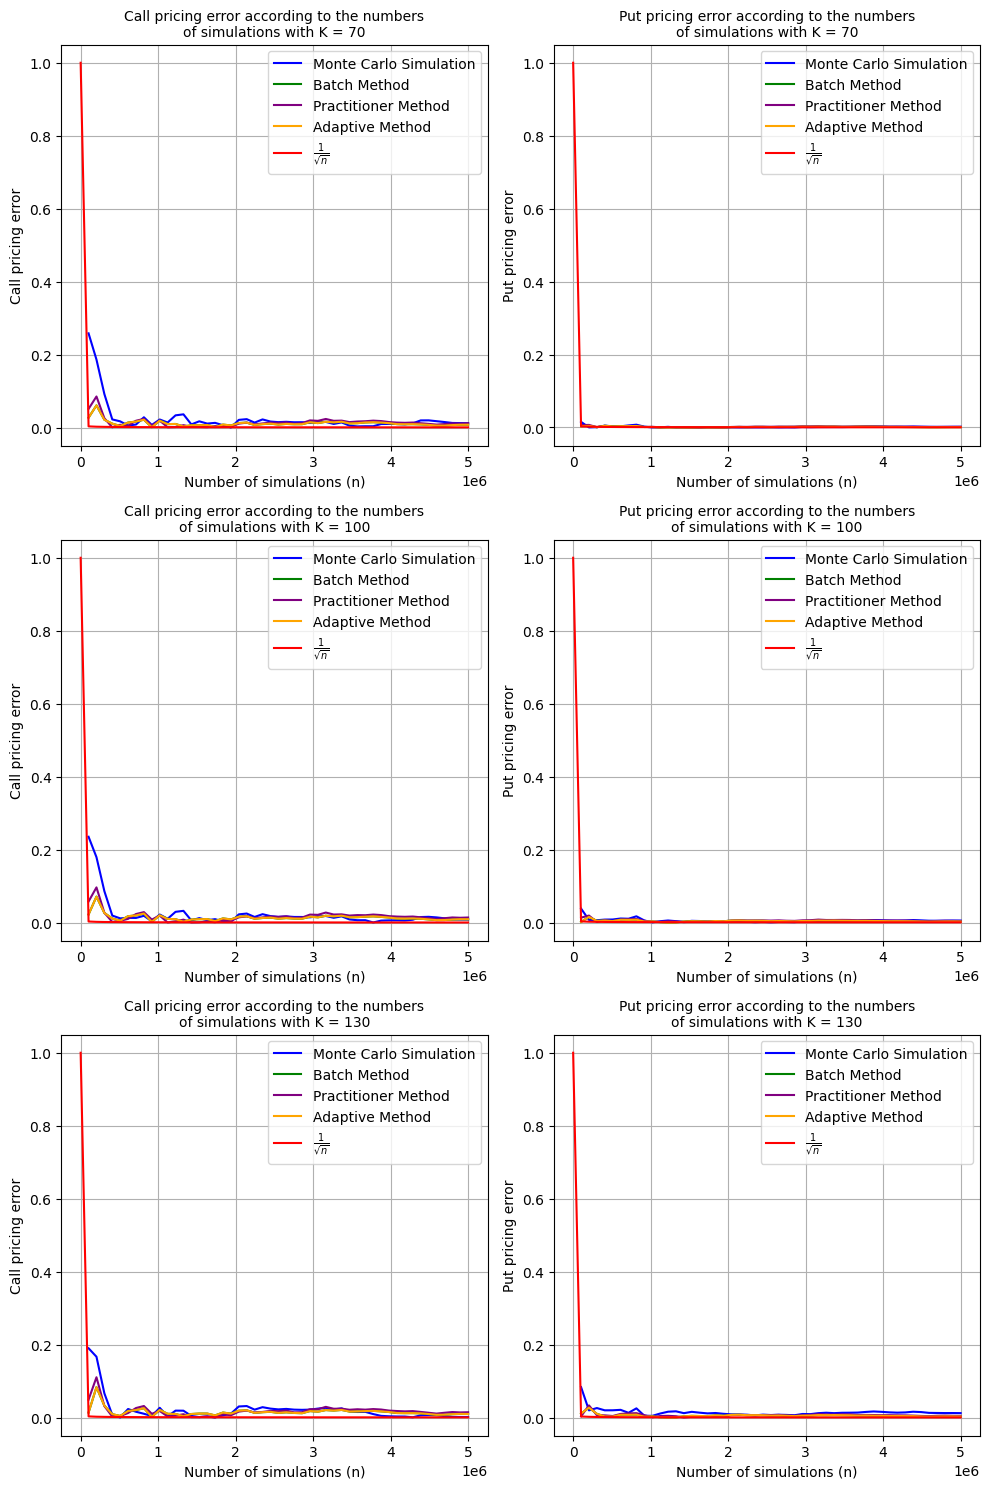

Time 5,000,000 prices generation: 0.20 seconds
Time computation estimators series for each K and each payoff function: 20.56 seconds
Time plot : 2.03 seconds
Total execution time for a total serie of 1,200 Monte Carlo methods: 22.88 seconds


In [80]:
#We plot to compare the CV of each methd and indicators with 1 / sqrt(n)
#We do a first naive version without zooming (the graph will be deformed by the very fast CV near 0)
beginning = time.time()  
print_data_convergence_error_according_to_n (S0_CV,r_CV,sigma_CV,T_CV,K_CV,n_CV, prix_option, payoff_function,option_type,nb_simu_wanted)
end = time.time() 
execution_time = end - beginning
print(f"Total execution time for a total serie of {8*len(K_CV)*nb_simu_wanted:,} Monte Carlo methods: {execution_time:.2f} seconds")

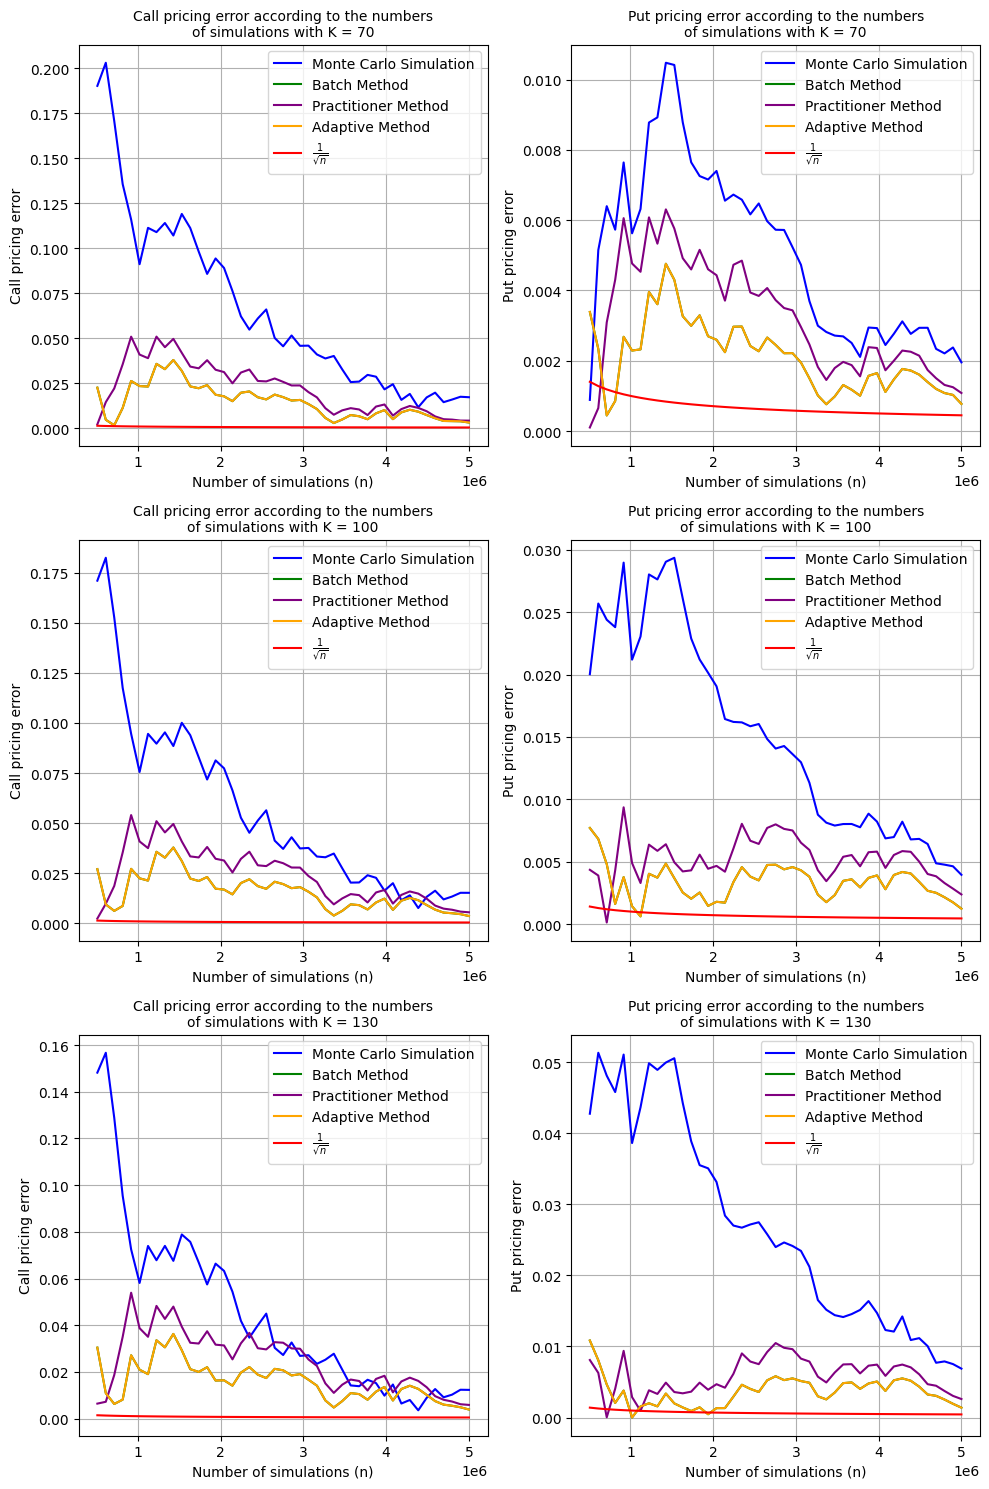

Time 5,000,000 prices generation: 0.17 seconds
Time computation estimators series for each K and each payoff function: 15.79 seconds
Time plot : 1.23 seconds
Total execution time for a total serie of 1,200 Monte Carlo methods: 17.35 seconds


In [82]:
#We do an approach to zoom only on the data on the end of the queue to delete the effect of this fast CV rate near 0
#The MC is done again so it is not the same curves as above
beginning = time.time()  
print_data_convergence_error_according_to_n (S0_CV,r_CV,sigma_CV,T_CV,K_CV,n_CV, prix_option, payoff_function,option_type,nb_simu_wanted,zoom=0.1)
end = time.time() 
execution_time = end - beginning
print(f"Total execution time for a total serie of {8*len(K_CV)*nb_simu_wanted:,} Monte Carlo methods: {execution_time:.2f} seconds")


We have the following main characteristics:

- Convergence of the error as the number of simulations convergence to the $O\left( \frac{1}{\sqrt{n}} \right) \to 0 \quad \text{as} \quad n \to \infty$.    
- Better asymptotic convergence for methods using variance reduction compared to the naive Monte Carlo method (test for higher n by reducing points, a bit longer), which exhibits high variance and therefore stronger variations. 
- The curves of the Batch method and the Adaptive method overlap.

  -> This is related to the asymptotic convergence of the results of Batch and Adaptive methods (for k large $\lambda_k \approx \lambda_{k-1}$ et $\tilde\lambda_k = \lambda_k$).
  

# <div style="font-size: 15px;">3.3. Graphical representation of the differences between BS prices and estimator for several strikes</div>

In [388]:
S0_strikes = 100     # Initial price of the underlying asset
r_strikes = 0.05     # Risk-free interest rate
sigma_strikes = 0.2  # Volatility
T_strikes = 8        # Maturity
strikes = [strike for strike in range(80, 125, 5)]  # Strike prices
number_strikes = [1000000,5000000,10000000]  # Number of simulations

Prices generation time for n = 10,000,000 : 0.34 seconds


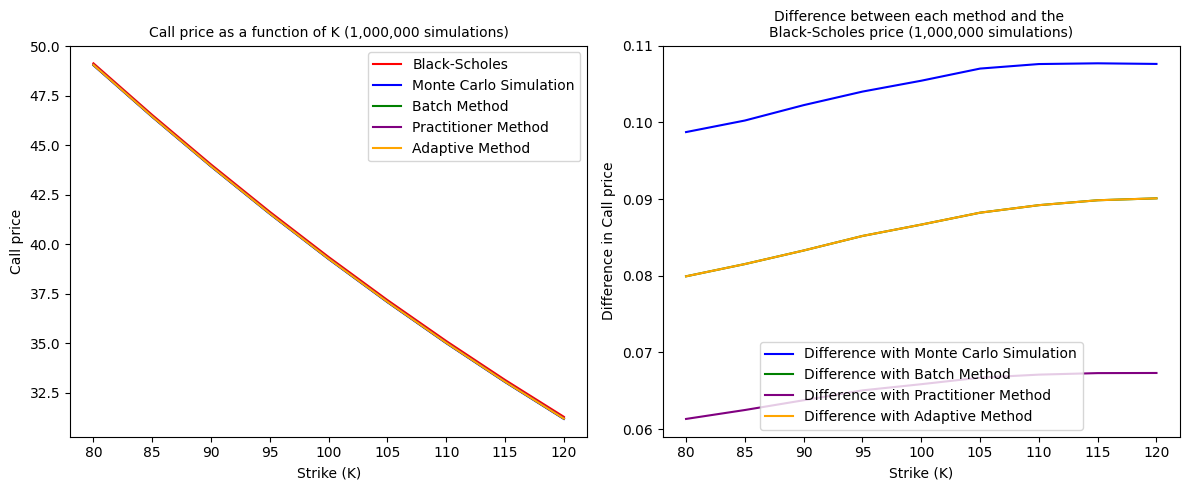

Methods execution time for n = 1,000,000 simulations: 0.28 seconds


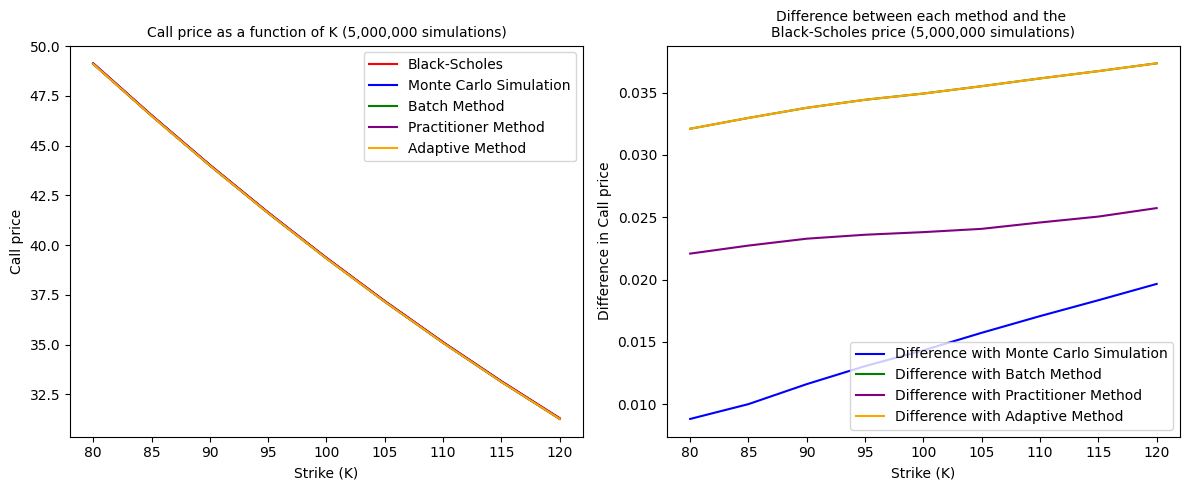

Methods execution time for n = 5,000,000 simulations: 1.32 seconds


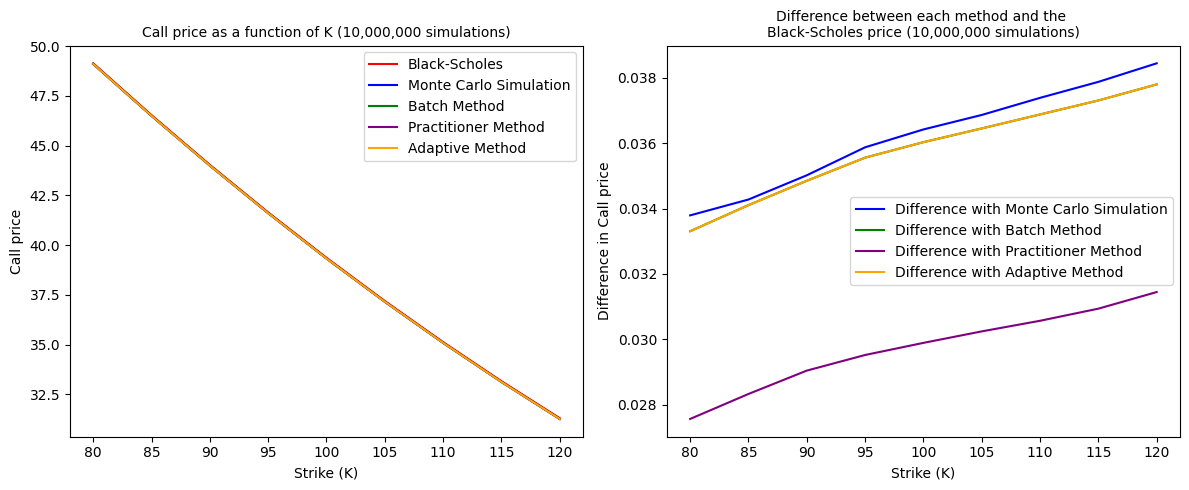

Methods execution time for n = 10,000,000 simulations: 2.62 seconds
Prices generation time for n = 10,000,000 : 0.42 seconds


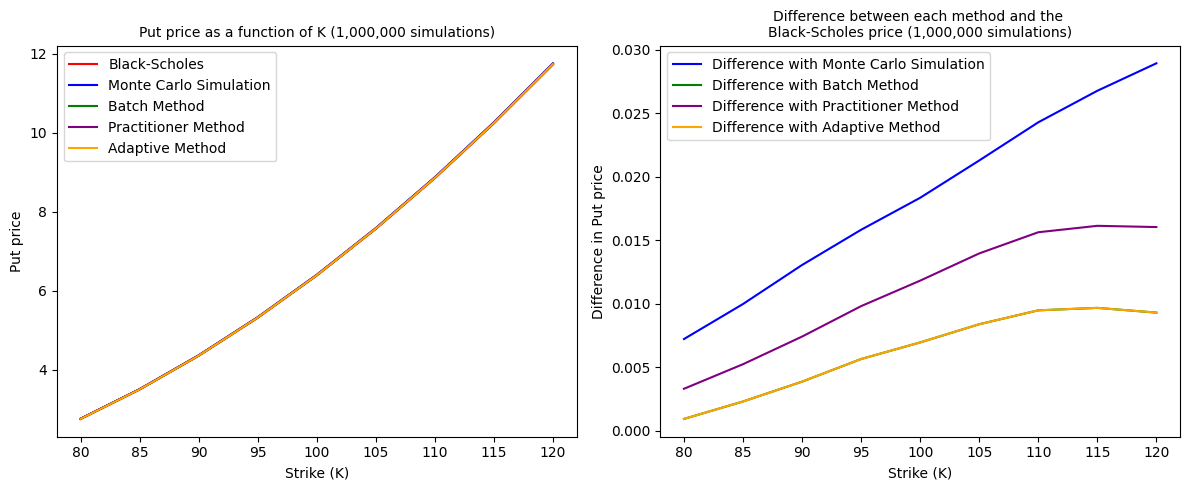

Methods execution time for n = 1,000,000 simulations: 0.31 seconds


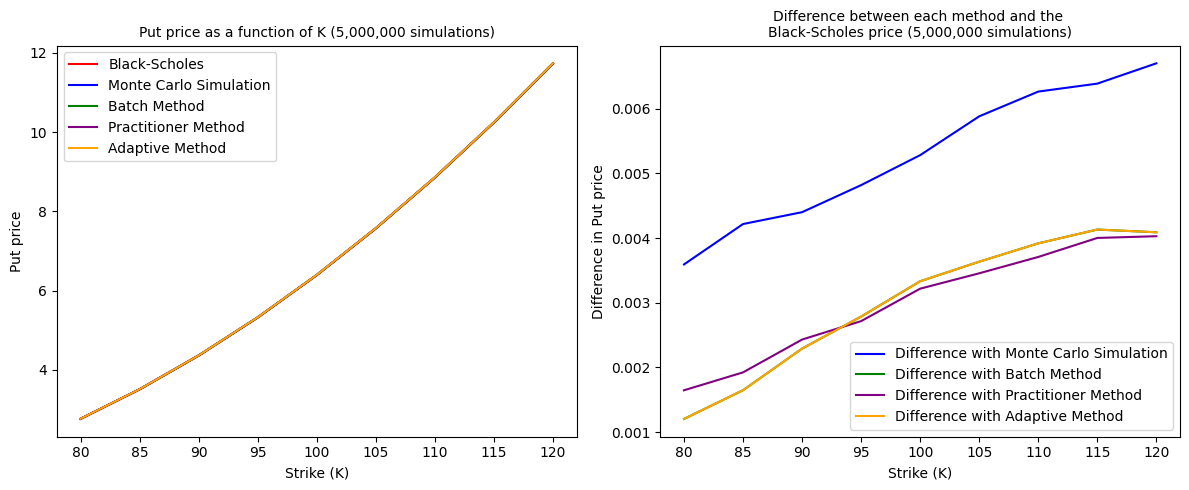

Methods execution time for n = 5,000,000 simulations: 1.36 seconds


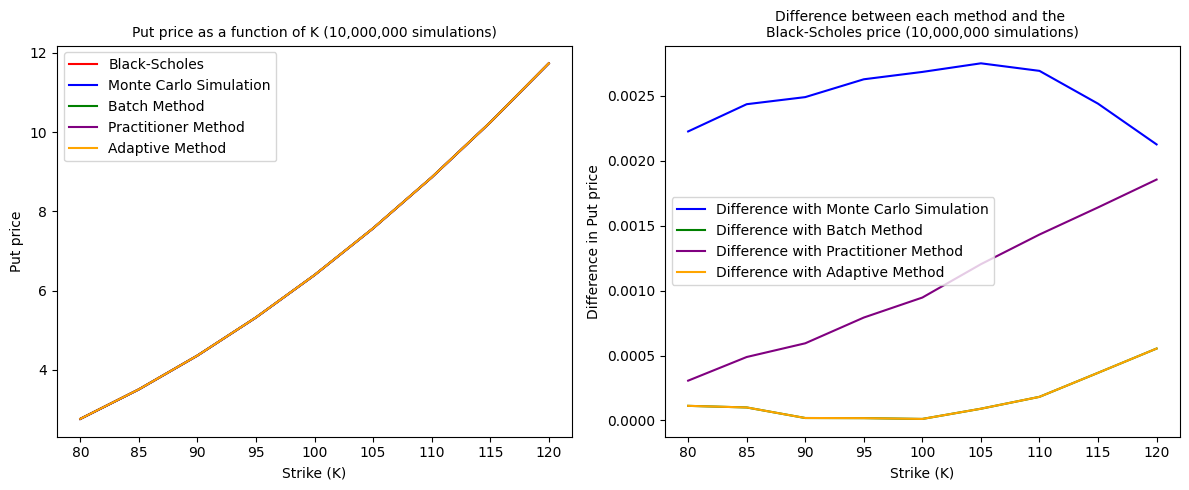

Methods execution time for n = 10,000,000 simulations: 2.72 seconds


In [391]:
plot_result (S0_strikes,r_strikes,sigma_strikes,T_strikes,strikes,number_strikes,call_price,payoff_call,option_type="Call")
plot_result (S0_strikes,r_strikes,sigma_strikes,T_strikes,strikes,number_strikes,put_price,payoff_put,option_type="Put")


We have the following main characteristics:

- The errors decrease as the number of simulations increases as shown before
- The methods using variance reduction methods perform better on an asymptotic perspective
- According to the nature of our option and if it is way out of the money(call) or in the money (put), our errors increase a little
- Asymptotic convergence of the results of Batch and Adaptive methods (for k large $\lambda_k \approx \lambda_{k-1}$ et $\tilde\lambda_k = \lambda_k$).